In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

# Modeling
from sklearn.model_selection import train_test_split

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import roc_auc_score

from sklearn.model_selection import RandomizedSearchCV
from collections import Counter

In [3]:
#Loading Dataset

train=pd.read_csv('train.csv')  # Loading the train dataset
test=pd.read_csv('test.csv')    # Loading the test dataset

target=train['Survived']

#detect outliers

def detect_outlier(df,n,cols):
    outlier_indices = []
    for i in cols:
        Q1 = np.percentile(df[i], 25)
        Q3 = np.percentile(df[i], 75)
        IQR = Q3 - Q1
        outlier_step = 1.5*IQR
        outlier_index_list = df[(df[i] < Q1-outlier_step) | (df[i] > Q3+outlier_step)].index
        outlier_indices.extend(outlier_index_list)
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list(k for k,v in outlier_indices.items() if v>n)  
    return multiple_outliers

outliers_to_drop = detect_outlier(train,3,['Age', 'SibSp', 'Parch', 'Fare'])
train = train.drop(outliers_to_drop, axis = 0).reset_index(drop=True)

#Basic info about the dataset

print('Shape of train dataset:-',train.shape)
print('Shape of test dataset:-' ,test.shape)

#Info about datatype and statistical model

print('\n')
print(train.info())
train.describe()

Shape of train dataset:- (891, 12)
Shape of test dataset:- (418, 11)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [4]:
#Combining both train and test dataset
total=pd.concat([train.drop('Survived',axis=1),test])
target=train['Survived']

total.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


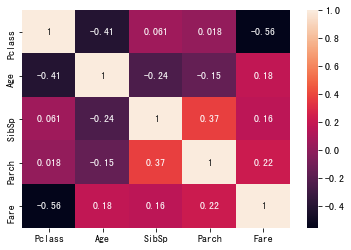

In [5]:
sns.heatmap(total.drop('PassengerId',axis=1).corr(),annot=True) #we are seeing the correlation of column with each other:-

Pclass  Sex   
1       female    96.808511
        male      36.885246
2       female    92.105263
        male      15.740741
3       female    50.000000
        male      13.544669
Name: Survived, dtype: float64 
 
If women is from 1st and 2nd class then it has a lot chance to survive about 92%


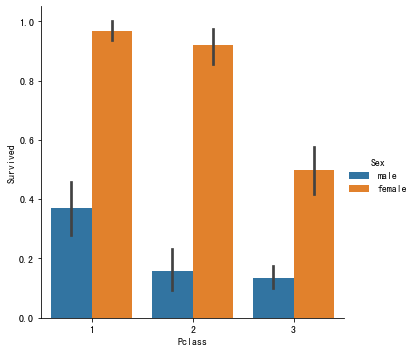

In [6]:
#Pclass vs Survival rate
sns.catplot(x='Pclass',y='Survived',data=train,kind='bar',hue='Sex')
print(train.groupby(['Pclass','Sex'])['Survived'].mean()*100,'\n','\nIf women is from 1st and 2nd class then it has a lot chance to survive about 92%')

Embarked  Sex   
C         female    0.876712
          male      0.305263
Q         female    0.750000
          male      0.073171
S         female    0.689655
          male      0.174603
Name: Survived, dtype: float64
Embarked  Sex     Pclass
C         female  1         0.976744
                  2         1.000000
                  3         0.652174
          male    1         0.404762
                  2         0.200000
                  3         0.232558
Q         female  1         1.000000
                  2         1.000000
                  3         0.727273
          male    1         0.000000
                  2         0.000000
                  3         0.076923
S         female  1         0.958333
                  2         0.910448
                  3         0.375000
          male    1         0.354430
                  2         0.154639
                  3         0.128302
Name: Survived, dtype: float64
If a female is from Southmpton it has 87% chance of surv

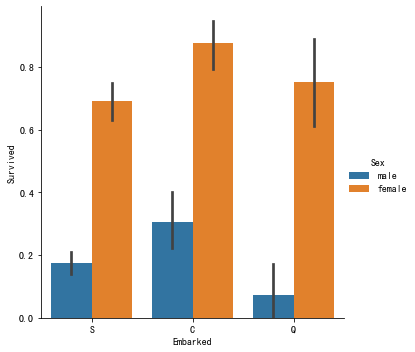

In [7]:
#Embarked vs Survived
sns.catplot(x='Embarked',y='Survived',data=train,kind='bar',hue='Sex')
print(train.groupby(['Embarked','Sex'])['Survived'].mean())
print(train.groupby(['Embarked','Sex','Pclass'])['Survived'].mean())
print('If a female is from Southmpton it has 87% chance of survival and\n if she is from Q it has 75% chance of survival')

SibSp
0    0.345395
1    0.535885
2    0.464286
3    0.250000
4    0.166667
5    0.000000
8    0.000000
Name: Survived, dtype: float64 

Family with more than 2 sibling has less chance to survive


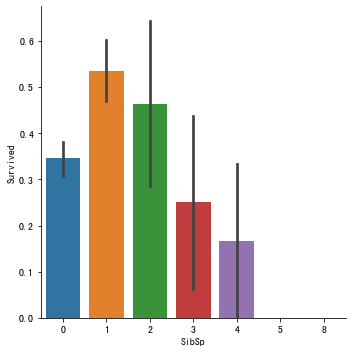

In [8]:
#SibSp vs Survival
sns.catplot(x='SibSp',y='Survived',data=train,kind='bar')
print(train.groupby('SibSp')['Survived'].mean(),'\n\nFamily with more than 2 sibling has less chance to survive')

In [9]:
print(train['Age'].describe())

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64


In [12]:
print(total.isnull().sum())
total['Age'] = total.groupby('Pclass')['Age'].transform(lambda x: x.fillna(x.median()))  #removing null value of Age with help of pclass
total['Fare'] = total.groupby('Pclass')['Fare'].transform(lambda x: x.fillna(x.median())) #removing null value of Fare with help of pclass
total['Embarked'].fillna('S',inplace=True)  #removing null value of Embarked with most common S

PassengerId       0
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              0
Cabin          1014
Embarked          0
dtype: int64


In [13]:
encoder=LabelEncoder()
total['Sex']=encoder.fit_transform(total['Sex'])
total['Embarked']=encoder.fit_transform(total['Embarked'])
total=pd.get_dummies(total,columns=['Pclass','Embarked'])

In [14]:
total['Fare_1_S']=total['Embarked_2']*total['Pclass_1']*total['Sex']

In [15]:
#Extracting Title from name
total['Title'] =total['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
total['Title'] =total['Title'].replace(['Lady', 'Countess','Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
total['Title'] =total['Title'].replace('Mlle', 'Miss')
total['Title'] =total['Title'].replace('Ms', 'Miss')
total['Title'] =total['Title'].replace('Mme', 'Mrs')
#Mapping titles to numerical data
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 2, "Master": 3, "Rare": 4}
total['Title'] =total['Title'].map(title_mapping)
total['Title'] =total['Title'].fillna(0)


#Extracting common ages into group
total['Age_cat'] = pd.qcut(total['Age'],q=[0, .16, .33, .49, .66, .83, 1], labels=False, precision=1)

#Fare group
def fare_category(fr): 
    if fr <= 7.91:
        return 1
    elif fr <= 14.454 and fr > 7.91:
        return 2
    elif fr <= 31 and fr > 14.454:
        return 3
    return 4
total['Fare_cat'] =total['Fare'].apply(fare_category) 


#Family group
total['FamilySize'] =total['SibSp'] + total['Parch'] + 1
total['FamilySize_cat'] =total['FamilySize'].map(lambda x: 1 if x == 1 
                                                            else (2 if 5 > x >= 2 
                                                                  else (3 if 8 > x >= 5 
                                                                       else 4 )    
                                                                 ))   

#Other columns to make 

In [16]:
total.drop(['Name','Ticket','Cabin'],axis=1,inplace=True)

#Dummy variable
total=pd.get_dummies(total,columns=['SibSp','Parch','Age_cat','Title','FamilySize','Fare_cat','FamilySize_cat'])

total['Age']=total['Age'].astype(int)

In [17]:
train=total[:len(train)]
test=total[len(train):]


np.random.seed(42)
# Split into train & test set
X_train, X_test, y_train, y_test = train_test_split(train,target, test_size = 0.25) 


models = {"KNN": KNeighborsClassifier(),
          "Logistic Regression": LogisticRegression(max_iter=10000), 
          "Random Forest": RandomForestClassifier(),
          "SVC" : SVC(probability=True),
          "DecisionTreeClassifier" : DecisionTreeClassifier(),
          "AdaBoostClassifier" : AdaBoostClassifier(),
          "GradientBoostingClassifier" : GradientBoostingClassifier(),
          "GaussianNB" : GaussianNB(),
          "LinearDiscriminantAnalysis" : LinearDiscriminantAnalysis(),
          "QuadraticDiscriminantAnalysis" : QuadraticDiscriminantAnalysis()}
def fit_and_score(models, X_train, X_test, y_train, y_test):

    # Random seed for reproducible results
    np.random.seed(42)
    # Make a list to keep model scores
    model_scores = {}
    # Loop through models
    for name, model in models.items():
        # Fit the model to the data
        model.fit(X_train, y_train)
        # Predicting target values
        y_pred = model.predict(X_test)
        # Evaluate the model and append its score to model_scores
        #model_scores[name] = model.score(X_test, y_test)
        model_scores[name] = roc_auc_score(y_pred, y_test)
    return model_scores
model_scores = fit_and_score(models=models,
                             X_train=X_train,
                             X_test=X_test,
                             y_train=y_train,
                             y_test=y_test)
model_scores

/Users/wujim/.pyenv/versions/3.7.6/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


{'KNN': 0.6374233128834356,
 'Logistic Regression': 0.8187065014428789,
 'Random Forest': 0.8033633033633034,
 'SVC': 0.6051643192488262,
 'DecisionTreeClassifier': 0.7674698795180724,
 'AdaBoostClassifier': 0.7953964194373402,
 'GradientBoostingClassifier': 0.8260383100608665,
 'GaussianNB': 0.674812030075188,
 'LinearDiscriminantAnalysis': 0.8187065014428789,
 'QuadraticDiscriminantAnalysis': 0.5759132420091324}

In [19]:
leaks = {
897:1,
899:1, 
930:1,
932:1,
949:1,
987:1,
995:1,
998:1,
999:1,
1016:1,
1047:1,
1083:1,
1097:1,
1099:1,
1103:1,
1115:1,
1118:1,
1135:1,
1143:1,
1152:1, 
1153:1,
1171:1,
1182:1,
1192:1,
1203:1,
1233:1,
1250:1,
1264:1,
1286:1,
935:0,
957:0,
972:0,
988:0,
1004:0,
1006:0,
1011:0,
1105:0,
1130:0,
1138:0,
1173:0,
1284:0,
}

model=GradientBoostingClassifier()
model.fit(train,target)
sub = pd.DataFrame()
sub['PassengerId'] = test['PassengerId']
sub['Survived'] = model.predict(test)
sub['Survived'] = sub['Survived'].apply(lambda x: 1 if x>0.8 else 0)
sub['Survived'] = sub.apply(lambda r: leaks[int(r['PassengerId'])] if int(r['PassengerId']) in leaks else r['Survived'], axis=1)
sub.to_csv('submission.csv', index=False)